# Machine Learning project a.y. 2021/2022

## Scikit-learn MLP model

## Importing libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast

from sklearn.base import clone as clone_model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from scipy.stats import randint
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingRegressor
from dataclasses import dataclass

## Loading training set and blind test set

In [ ]:
df_visual = pd.read_csv('./data/ML-CUP21-TR.csv', usecols=[11,12], names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df_task_tr = pd.read_csv('./data/ML-CUP21-TR.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df_task_tr = df_task_tr[7:] # remove first 7 rows of comments
df_visual = df_visual[7:]

df_blind_ts = pd.read_csv('./data/ML-CUP21-TS.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10'])
df_blind_ts = df_blind_ts[7:]
df_blind_ts.drop(labels="idx", axis=1, inplace=True)
blind_ts = df_blind_ts.values

## Evaluation metrics and tools

We define the <b>MEE (Mean Euclidean Error)</b> function which is used to evaluate the mean euclidean distance between two points with x and y coordinates.
The function takes in input the true target and the predicted target and yields a floating point number which represents the performance. 

In [ ]:
def mee(true_target, predicted_target): #assuming target is 2-dim matrix with x and y as columns
    l = true_target.shape[0]
    res = 0
    
    for p in range(l): #for p-th pattern in l (number of samples)
        x_diff = np.square(true_target[p,0] - predicted_target[p,0]) #difference between the x value of the true and predicted target
        y_diff = np.square(true_target[p,1] - predicted_target[p,1]) #difference between the y values of true and predicted target
        sum_term = x_diff + y_diff
        res = res + np.sqrt(sum_term)
    res = res / l
    
    #return np.average([np.sqrt(np.square(true_target[p,0] - predicted_target[p,0]) + np.square(true_target[p,1] - predicted_target[p,1])) for p in range(l)]) #compact form
    return res

In [ ]:
def plot_learning_curves(train_scores, test_scores, epochs, y_label, ax, i):
    ax.set_title(f"Model {i+1}")
    ax.set_ylabel(y_label)
    ax.set_xlabel('Epoch');
    ax.plot(range(0,epochs), train_scores, label = "Training error", linestyle='dashed')
    ax.plot(range(0,epochs), test_scores, label = "Test error")
    ax.legend()

    return ax

We also define a random state (seed) to allow reproducibility on our experiments

In [ ]:
RS_NUMBER = 69

## Regression task

### Preparing the training set

In [ ]:
df_task_tr.drop(labels="idx", axis=1, inplace=True)

In [ ]:
y = df_task_tr[['x','y']].values
X = df_task_tr.drop(labels=['x','y'], axis=1).values
X_all = X
y_all = y

In [ ]:
print(X.shape)
print(y.shape)

(1477, 10)
(1477, 2)


### Internal Test set
We split the data set obtaining an internal test set (10%), we will use this internal test at the end to test internally the generalization error

In [ ]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.1, random_state=RS_NUMBER)
print(f"X shape: {X.shape}")
print(f"X internal test shape: {X_test.shape}")
print(f"y shape: {y.shape}")
print(f"y internal test shape: {y_test.shape}")

X shape: (1329, 10)
X internal test shape: (148, 10)
y shape: (1329, 2)
y internal test shape: (148, 2)


In [ ]:
#trains the model with one iteration (epoch) and computes in output a list of train and test scores using MEE
def fit_and_score(epochs, eval_model, X_train, y_train, X_test, y_test):
    train_scores = []
    test_scores = []
    train_loss = []
    test_loss = []
    for i in range(epochs):
        eval_model = eval_model.partial_fit(X_train,y_train)
        y_train_predicted = eval_model.predict(X_train)
        y_test_predicted = eval_model.predict(X_test)
        #results on train set
        train_scores.append(mean_squared_error(y_train, y_train_predicted))
        test_scores.append(mean_squared_error(y_test, y_test_predicted))
        #result on test set
        train_loss.append(mee(y_train, y_train_predicted))
        test_loss.append(mee(y_test, y_test_predicted))
    return train_scores, test_scores, train_loss, test_loss


## Randomized Search

In [ ]:
# define the number of iterations
n_iter_search = 1000
# define number of k-folds
k = 10

In [ ]:
%%time
%%script false --no-raise-error

# to find the best set of parameter setting, we can run a randomized search

# define the parameters' values
params = {
    "hidden_layer_sizes": [
        (10,),(25,),(50,),(75,),(100,),
        (10, 10),(25, 25),(50, 50),(75,75),(100, 100),],
    "activation" : ["logistic", "tanh", "relu"],
    "solver": ["sgd"],
    "learning_rate": ["constant"],
    "learning_rate_init": uniform(0.001, 0.5),
    "alpha": uniform(0.0001, 0.1),
    "momentum": [0.8, 0.85, 0.9],
    "batch_size": randint(1, X.shape[0]),
    "n_iter_no_change": [5,15,25],
    "random_state": [RS_NUMBER],
    "tol": uniform(0.001,0.0001),
    "early_stopping": [True],
    "validation_fraction": [0.2],
    "max_iter": [1000],
}

# define the grid search
rand_gs = RandomizedSearchCV(
    MLPRegressor(),
    param_distributions=params,
    n_iter=n_iter_search,
    n_jobs=-1,
    scoring=make_scorer(mee), #scoring is based on the highest value
    cv=k,
    random_state=RS_NUMBER,
    verbose=10
)
# run the grid search
rand_gs.fit(X, y)


CPU times: user 0 ns, sys: 8.03 ms, total: 8.03 ms
Wall time: 9.84 ms


In [ ]:
%%script false --no-raise-error

df_results = pd.DataFrame(data=rand_gs.cv_results_) #trasform into a pandas dataframe
df_results.sort_values(by="rank_test_score", axis=0, ascending=False, inplace=True) #sort rank values in decreasing order 
df_results.dropna(inplace=True) #delete nan values 
df_results = df_results[:50] #keep only top 50 models
pd.DataFrame.to_csv(df_results, "sklearn_results/rand1_search.csv")

In [ ]:
df_results = pd.read_csv("sklearn_results/rand1_search.csv")
df_results.head()


,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_batch_size,param_early_stopping,param_hidden_layer_sizes,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,34,0.595204,0.091717,0.001360,0.000451,logistic,0.097877,617,True,"(10, 10)",...,1.187962,1.243514,1.248355,1.175462,1.103753,1.209866,1.076233,1.159245,0.071420,708
1,376,1.959242,0.332358,0.004136,0.005216,tanh,0.010215,207,True,"(100,)",...,1.281780,1.231567,1.240610,1.147828,1.079353,1.216300,1.018891,1.162812,0.079374,707
2,479,8.412137,2.513098,0.003645,0.003561,tanh,0.009980,11,True,"(50, 50)",...,1.310843,1.191604,1.214154,1.136242,1.046369,1.189853,1.195349,1.170268,0.066577,706
3,489,0.867322,0.146675,0.004857,0.005426,logistic,0.071688,266,True,"(25, 25)",...,1.240382,1.220562,1.292879,1.183039,1.135890,1.270348,1.082014,1.172544,0.086502,705
4,898,1.034773,0.191381,0.006956,0.006762,logistic,0.048495,266,True,"(100,)",...,1.263232,1.260709,1.237734,1.144994,1.119754,1.249629,1.084389,1.173295,0.068731,704


In [ ]:
#get the best params for the grid search (cannot use rand_gs.best_estimator directly since it will yield the worst estimator based on MEE)
best_params = df_results['params'][0]
print(f"Mean error on the {k}-folds (MEE) on best model: {df_results['mean_test_score'][0]}\n")
print(f"Best params: {best_params}")

Mean error on the 10-folds (MEE) on best model: 1.159245340891908

Best params: {'activation': 'logistic', 'alpha': 0.09787683803526277, 'batch_size': 617, 'early_stopping': True, 'hidden_layer_sizes': (10, 10), 'learning_rate': 'constant', 'learning_rate_init': 0.10508617270418807, 'max_iter': 1000, 'momentum': 0.85, 'n_iter_no_change': 25, 'random_state': 69, 'solver': 'sgd', 'tol': 0.0010191286317139513, 'validation_fraction': 0.2}


In [ ]:
@dataclass
class GridSearchRanges:
    '''Class of keeping track of the min and max values for the hyperparameters tuning'''
    
    hidden_range = []
    min_lr_init = 0
    max_lr_init = 0
    min_alpha = 0
    max_alpha = 0
    min_bs = 0
    max_bs = 0
    n_iter_no_change = []
    min_tol = 0
    max_tol = 0
    min_momentum = 0
    max_momentum = 0
    
    def set_ranges(self):

        self.hidden_range = np.unique(df_results['param_hidden_layer_sizes'])
        self.hidden_range = self.hidden_range.ravel() #convert to array
        print(self.hidden_range)

        self.min_lr_init = np.min(df_results['param_learning_rate_init'])
        self.max_lr_init = np.max(df_results['param_learning_rate_init'])
        print(f"LR: [{self.min_lr_init}, {self.max_lr_init}]")

        self.min_alpha = np.min(df_results['param_alpha'])
        self.max_alpha = np.max(df_results['param_alpha'])
        print(f"alpha: [{self.min_alpha}, {self.max_alpha}]")

        self.min_bs = np.min(df_results['param_batch_size'])
        self.max_bs = np.max(df_results['param_batch_size'])
        print(f"BATCH: [{self.min_bs}, {self.max_bs}]")

        self.n_iter_no_change_range = np.unique(df_results['param_n_iter_no_change'])
        self.n_iter_no_change_range = self.n_iter_no_change_range.ravel()
        print(f"n_iter_no_change: {self.n_iter_no_change_range}")

        self.min_tol = np.min(df_results['param_tol'])
        self.max_tol = np.max(df_results['param_tol'])
        print(f"TOL: [{self.min_tol}, {self.max_tol}]")
    
        self.min_momentum = np.min(df_results['param_momentum'])
        self.max_momentum = np.max(df_results['param_momentum'])
        print(f"MOMENTUM: [{self.min_momentum}, {self.max_momentum}]")
    
    

In [ ]:
gs = GridSearchRanges()
gs.set_ranges()
gs.hidden_range = [ast.literal_eval(x) for x in gs.hidden_range]

['(10, 10)' '(10,)' '(100,)' '(25, 25)' '(25,)' '(50, 50)' '(50,)'
 '(75, 75)' '(75,)']
LR: [0.0098335487774382, 0.266267712436829]
alpha: [0.0014457204293714, 0.0997555754216904]
BATCH: [3, 1307]
n_iter_no_change: [ 5 15 25]
TOL: [0.0010017022228043, 0.0010995758202881]
MOMENTUM: [0.8, 0.9]


### Second Randomized Search using min e max values

In [ ]:
%%time
%%script false --no-raise-error

# define the parameters values
params = {
    "hidden_layer_sizes": gs.hidden_range,
    "activation" : ["logistic", "tanh"],
    "solver": ["sgd"],
    "learning_rate": ["constant", "adaptive", "invscaling"],
    "learning_rate_init": uniform(gs.min_lr_init, gs.max_lr_init),
    "alpha": uniform(gs.min_alpha, gs.max_alpha),
    "batch_size": randint(gs.min_bs, gs.max_bs),
    "n_iter_no_change": [5, 15, 25],
    "momentum": [0.8, 0.85, 0.9],
    "random_state": [RS_NUMBER],
    "tol": uniform(gs.min_tol,gs.max_tol),
    "early_stopping": [True],
    "validation_fraction": [0.2],
    "max_iter": [1000],
}

# define the grid search
rand_gs = RandomizedSearchCV(
    MLPRegressor(),
    param_distributions=params,
    n_iter=n_iter_search,
    n_jobs=-1,
    scoring=make_scorer(mee), #scoring is based on the highest value
    cv=k,
    random_state = RS_NUMBER,
    verbose=10,
)
# run the grid search
rand_gs.fit(X, y)


CPU times: user 0 ns, sys: 7.7 ms, total: 7.7 ms
Wall time: 8.71 ms


In [ ]:
%%script false --no-raise-error

df_results = pd.DataFrame(data=rand_gs.cv_results_) #trasform into a pandas dataframe
df_results.sort_values(by="rank_test_score", axis=0, ascending=False, inplace=True) #sort rank values in decreasing order 
df_results.dropna(inplace=True) #delete nan values 
df_results = df_results[:50] #keep only top 50 models
pd.DataFrame.to_csv(df_results, "sklearn_results/rand2_search.csv")

In [ ]:
df_results = pd.read_csv("sklearn_results/rand2_search.csv")
df_results

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_batch_size,param_early_stopping,param_hidden_layer_sizes,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,393,7.127462,0.741473,0.005884,0.005205,tanh,0.054117,123,True,"(75, 75)",...,1.214156,1.212419,1.221896,1.166389,1.051015,1.205769,1.019584,1.134050,0.079941,971
1,952,3.059202,0.270122,0.001215,0.000379,logistic,0.071183,67,True,"(25,)",...,1.250288,1.217157,1.253775,1.149673,1.099894,1.258694,1.039619,1.161720,0.076875,969
2,620,0.623801,0.107581,0.003977,0.005141,logistic,0.081040,88,True,"(10, 10)",...,1.198428,1.232720,1.259360,1.145410,1.082819,1.243615,1.069029,1.162133,0.072073,968
3,169,1.636803,0.387340,0.003847,0.004798,logistic,0.059974,386,True,"(10, 10)",...,1.191140,1.245164,1.239687,1.206727,1.083169,1.219111,1.076501,1.163560,0.075796,967
4,604,3.996523,0.234918,0.002843,0.004661,logistic,0.061200,63,True,"(75,)",...,1.225768,1.217156,1.268476,1.246247,1.081184,1.255246,0.992317,1.165388,0.090592,966
5,600,10.511407,0.801545,0.006472,0.005196,tanh,0.092936,547,True,"(75, 75)",...,1.259753,1.253994,1.240033,1.213744,1.071534,1.241136,1.047628,1.165437,0.081662,965
6,985,0.679341,0.156635,0.006342,0.006719,logistic,0.092056,216,True,"(10, 10)",...,1.229573,1.283432,1.283813,1.134536,1.081237,1.196321,1.059834,1.165577,0.092343,964
7,396,0.973764,0.146068,0.003433,0.006202,logistic,0.019126,176,True,"(10, 10)",...,1.197986,1.245270,1.250792,1.165350,1.096389,1.204851,1.115262,1.167302,0.063827,963
8,863,3.159622,0.467820,0.007625,0.007044,logistic,0.054738,60,True,"(50, 50)",...,1.246543,1.247597,1.235015,1.196714,1.077533,1.258444,1.072853,1.168565,0.079482,962
9,172,0.569086,0.125801,0.001535,0.001183,logistic,0.032258,300,True,"(25, 25)",...,1.216907,1.229907,1.275124,1.180864,1.111839,1.316293,1.038421,1.170445,0.094434,961


In [ ]:
#get the best params for the grid search (cannot use rand_gs.best_estimator directly since it will yield the worst estimator based on MEE)
best_params = df_results['params'][0]
print(f"Mean error on the {k}-folds (MEE) on best model: {df_results['mean_test_score'][0]}\n")
print(f"Best params: {best_params}")

Mean error on the 10-folds (MEE) on best model: 1.13405033190412

Best params: {'activation': 'tanh', 'alpha': 0.05411658766187596, 'batch_size': 123, 'early_stopping': True, 'hidden_layer_sizes': (75, 75), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01492564455111515, 'max_iter': 1000, 'momentum': 0.85, 'n_iter_no_change': 15, 'random_state': 69, 'solver': 'sgd', 'tol': 0.0010965248580978662, 'validation_fraction': 0.2}


## Model assessment 

We store the top 10 models in order to compose the final model (average voting committee).

In [ ]:
best_models = list() #list of the top ten models of the final randomized search
eval_best_models = list()

for i in range(10):
    best_params_i = df_results['params'][i]
    best_params_i = ast.literal_eval(best_params_i)
    print(best_params_i)
    
    model_i = MLPRegressor(**best_params_i)
    best_params_i['early_stopping'] = False
    model_i_eval = MLPRegressor(**best_params_i)
    best_models.append(model_i)
    eval_best_models.append(model_i_eval)

{'activation': 'tanh', 'alpha': 0.05411658766187596, 'batch_size': 123, 'early_stopping': True, 'hidden_layer_sizes': (75, 75), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01492564455111515, 'max_iter': 1000, 'momentum': 0.85, 'n_iter_no_change': 15, 'random_state': 69, 'solver': 'sgd', 'tol': 0.0010965248580978662, 'validation_fraction': 0.2}
{'activation': 'logistic', 'alpha': 0.07118331505308412, 'batch_size': 67, 'early_stopping': True, 'hidden_layer_sizes': (25,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.06957707631735699, 'max_iter': 1000, 'momentum': 0.85, 'n_iter_no_change': 15, 'random_state': 69, 'solver': 'sgd', 'tol': 0.0019326355889529127, 'validation_fraction': 0.2}
{'activation': 'logistic', 'alpha': 0.08103975825510298, 'batch_size': 88, 'early_stopping': True, 'hidden_layer_sizes': (10, 10), 'learning_rate': 'constant', 'learning_rate_init': 0.08185962085289768, 'max_iter': 1000, 'momentum': 0.8, 'n_iter_no_change': 15, 'random_state': 69, 'solver'

We fit each one of the model and we also save the number of epochs which is used later to plot the learning curves.

In [ ]:
epochs_best_models = list()

#fit every model
for model in best_models:
    model.fit(X,y)
    epochs_best_models.append(model.n_iter_)

We compute the predictions on the development set (X), the internal test set (X_test) and on the blind test set (blind_ts) of each model.

In [ ]:
y_predictions_train = list()
y_predictions_internal_test = list()
y_predictions_blind_test = list()

#predictions on every model is averaged
for model in best_models:
    #prediction on TRAINING SET
    y_pred = model.predict(X)
    y_predictions_train.append(y_pred)
    
    #prediction on INTERNAL TEST SET
    y_pred = model.predict(X_test)
    y_predictions_internal_test.append(y_pred)

    #prediction on BLIND TEST SET
    y_pred = model.predict(blind_ts)
    y_predictions_blind_test.append(y_pred)

We finally compute the average of the predictions for training set, internal test set and blind test set.

In [ ]:
y_pred_voting_ens_train_set = np.average(y_predictions_train, axis=0)
y_pred_voting_ens_internal_test = np.average(y_predictions_internal_test, axis=0)

print(f"MEE on train set: {mee(y, y_pred_voting_ens_train_set)}")
print(f"MEE on internal test set: {mee(y_test, y_pred_voting_ens_internal_test)}")

MEE on train set: 1.0925512138619808
MEE on internal test set: 1.0750268410826826


The evaluation models are used to store and then plot the loss values.

In [ ]:
loss_train_best_models = list()
loss_test_best_models = list()

for i in range(len(eval_best_models)):
    epochs = epochs_best_models[i]
    eval_model = eval_best_models[i]
    score_train, score_test, loss_train, loss_test = fit_and_score(epochs, eval_model, X, y, X_test, y_test)
    loss_train_best_models.append(loss_train)
    loss_test_best_models.append(loss_test)

## Learning Curves

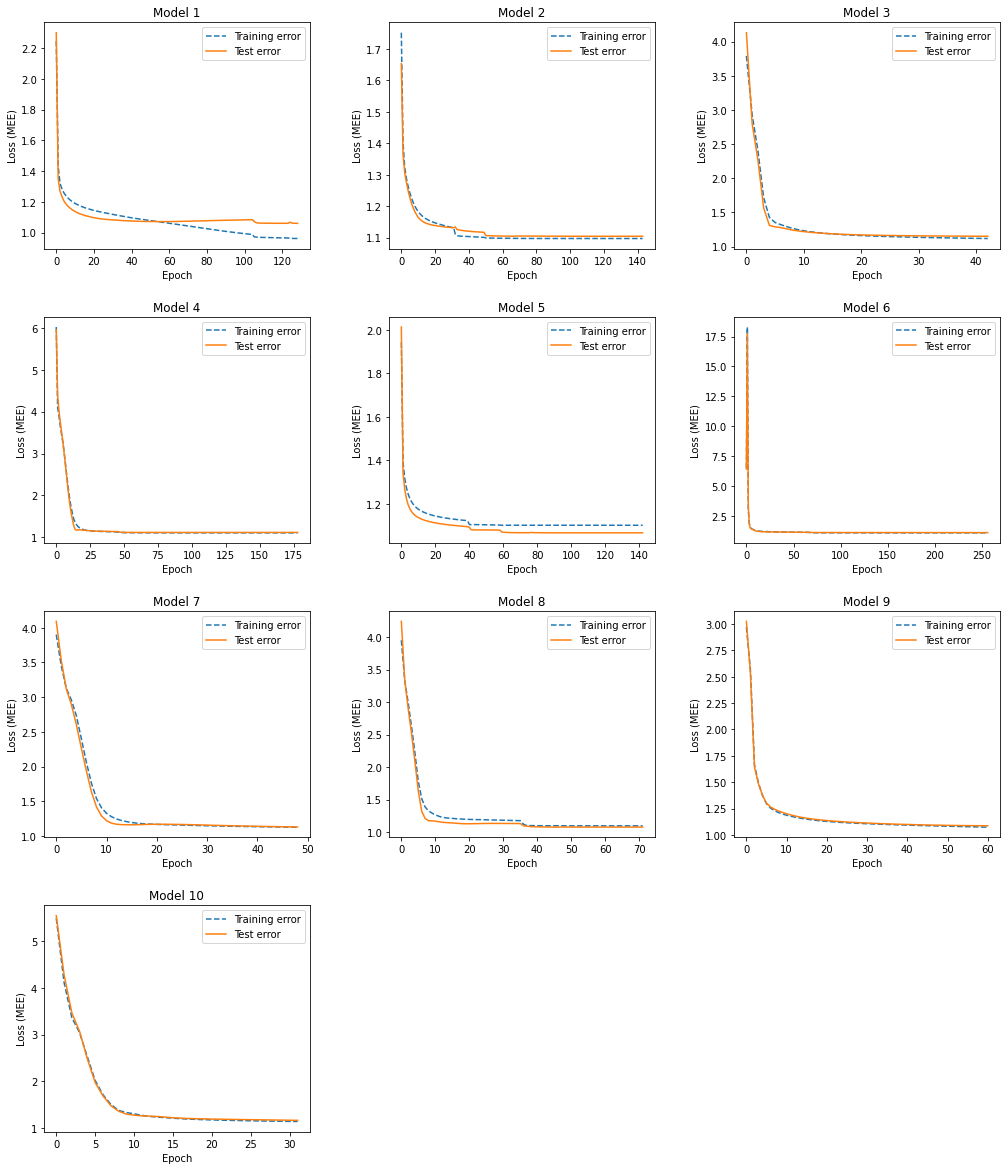

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(14,16))
axes = axes.flatten()
fig.tight_layout()

for i in range(len(eval_best_models)):
    epochs = epochs_best_models[i]
    loss_train = loss_train_best_models[i]
    loss_test = loss_test_best_models[i]
    plot_learning_curves(loss_train, loss_test, epochs, "Loss (MEE)", axes[i], i)

fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(wspace=0.3)
fig.delaxes(axes[10])
fig.delaxes(axes[11])

### Multiple runs on the internal test set and training set

We make sure that we did not pick a lucky case by running the model on ten different initializations of the weights.

In [ ]:
from random import randint as random_number

y_pred_train_list = list()
y_pred_test_list = list()

for i in range(10):
    best_models = list() #list of the top ten models of the final randomized search

    for i in range(10):
        best_params_i = df_results['params'][i]
        best_params_i = ast.literal_eval(best_params_i)
        best_params_i['random_state'] = random_number(1,1000)
        model_i = MLPRegressor(**best_params_i)
        best_models.append(model_i)
    
    y_predictions_train = list()
    y_predictions_internal_test = list()

    #predictions on every model is averaged
    for model in best_models:
        model.fit(X,y)
        #prediction on TRAINING SET
        y_pred = model.predict(X)
        y_predictions_train.append(y_pred)
        
        #prediction on INTERNAL TEST SET
        y_pred = model.predict(X_test)
        y_predictions_internal_test.append(y_pred)


    y_pred_voting_ens_train_set = np.average(y_predictions_train, axis=0)
    y_pred_voting_ens_internal_test = np.average(y_predictions_internal_test, axis=0)

    y_pred_train_list.append(mee(y, y_pred_voting_ens_train_set))
    y_pred_test_list.append(mee(y_test, y_pred_voting_ens_internal_test))



#### Internal Test Set

In [ ]:
avg = sum(y_pred_test_list)/len(y_pred_test_list)
var = sum((x-avg)**2 for x in y_pred_test_list) / len(y_pred_test_list)
print(f"average MEE: {avg}")
print(f"variance MEE: {var}")

average MEE: 1.092425014392471
variance MEE: 5.793035056099513e-05


#### Training Set

In [ ]:
avg = sum(y_pred_train_list)/len(y_pred_train_list)
var = sum((x-avg)**2 for x in y_pred_train_list) / len(y_pred_train_list)
print(f"average MEE: {avg}")
print(f"variance MEE: {var}")

average MEE: 1.0975878778958577
variance MEE: 2.867980977306271e-05


### Final predictions on the blind test set

In [ ]:
y_pred_voting_ens_blind_test = np.average(y_predictions_blind_test, axis=0)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d9d840c9-75b3-4185-bb01-105f5cca8d83' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>